# Foraging toolkit demo - approximate inference analysis on Central Park birds data

## Outline
* [Introduction](#introduction)
* [Data processing](#data-processing)
  * [Load data](#load-data)
  * [Visualize trajectories](#visualize-trajectories)
  * [Analyze mutual distance distribution](#analyze-mutual-distance-distribution)
* [Inference](#inference-with-a-specific-quantitative-hypothesis)
  * [Predictors derivation](#predictors-derivation)
  * [Predictors visualization](#predictors-visualization)
  * [Model fit](#model-fit)
* [Results](#results)
  * [Ducks](#ducks)
  * [Sparrows](#sparrows)
  * [Comparison](#comparison)

## Introduction

This notebook demonstrates using the foraging toolkit to analyze movements of birds recorded in Central Park, NYC, as described in the paper [1], Fig. 4.

The users are advised to read through the demo notebooks in [`docs/foraging/random-hungry-followers`](../random-hungry-followers/) folder to familiarize themselves with the foraging toolkit, and, specifically, with computing predictors and running inference.

---

[1] R. Urbaniak, M. Xie, and E. Mackevicius, “Linking cognitive strategy, neural mechanism, and movement statistics in group foraging behaviors,” Sci Rep, vol. 14, no. 1, p. 21770, Sep. 2024, [doi: 10.1038/s41598-024-71931-0.](https://www.nature.com/articles/s41598-024-71931-0)

In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os

import dill
import matplotlib.pyplot as plt
import pandas as pd

import collab.foraging.toolkit as ft
from collab.foraging.toolkit import dataObject, plot_predictor

logging.basicConfig(format="%(message)s", level=logging.INFO)

from collab.utils import find_repo_root

root = find_repo_root()

import plotly.io as pio

pio.renderers.default = "notebook"

# users can ignore smoke_test -- it's for automatic testing on GitHub,
# to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
frames = 150 if smoke_test else 300
frames_sps = 150 if smoke_test else 300
sampling_rate = 0.001 if smoke_test else 0.01
num_svi_iters = 100 if smoke_test else 1000
num_samples = 100 if smoke_test else 1000

## Data processing

### Load data

First, we convert the raw data into foraging toolkit format. Our methods expect a `dataObject` with `foragersDF` property, which is a `DataFrame`  with columns `time,forager,x,y`. We use the toolkit utilities to subsample and rescale the data.

Notice that `NaN` values are valid, indicating that a certain forager was not detected in a certain time frame. The warning remains, as depending on the hypotheses and goals of a researcher, one might want to make a decision whether frames where at least one animal disappears are pathological and should be disposed of. In this case, we expect some missing data, as the birds were observed in the wild within a limited area, and sometimes leave the field of view.

In [2]:
ducks_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221215122046189_-5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)
sparrows_raw = pd.read_csv(
    os.path.join(
        root,
        "data/foraging/central_park_birds_cleaned_2022/20221229124843603_n5_25_bone.avi.hand_checked_cleaned_df.csv",
    )
)

ducks_raw = ducks_raw.rename(columns={"bird": "forager"})
sparrows_raw = sparrows_raw.rename(columns={"bird": "forager"})

ducks_sub = ft.subset_frames_evenly_spaced(ducks_raw, frames)
ducks_sub = ft.rescale_to_grid(ducks_sub, 90)
ducks_object = dataObject(foragersDF=ducks_sub)

sps_sub = ft.subset_frames_evenly_spaced(sparrows_raw, frames_sps)
sps_sub = ft.rescale_to_grid(sps_sub, 90)
sps_object = dataObject(foragersDF=sps_sub)

print(
    f"\nDucks:\n------\n {ducks_object.foragersDF.head()}\n\nSparrows:\n--------\n {sps_object.foragersDF.head()}"
)

original_frames: 1451
original_shape: (8867, 4)
resulting_frames: 300
resulting_shape: (1848, 4)
original_frames: 11550
original_shape: (22821, 4)
resulting_frames: 279
resulting_shape: (617, 4)

Ducks:
------
     x   y  time  forager
0 NaN NaN     0        0
1 NaN NaN     1        0
2 NaN NaN     2        0
3 NaN NaN     3        0
4 NaN NaN     4        0

Sparrows:
--------
     x   y  time  forager
0 NaN NaN     0        0
1 NaN NaN     1        0
2 NaN NaN     2        0
3 NaN NaN     3        0
4 NaN NaN     4        0


/Users/emily/code/collaborative-intelligence/collab/foraging/toolkit/utils.py:62: UserWarning:


                    Missing frames encountered for forager 0, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    

/Users/emily/code/collaborative-intelligence/collab/foraging/toolkit/utils.py:62: UserWarning:


                    Missing frames encountered for forager 1, adding NaN fillers.
                    The default behavior of predictor/score generating functions is
                    to ignore foragers with missing positional data. To modify, see documentation of
                    `derive_predictors_and_scores` and `generate_local_windows`
                    

/Users/emily/code/collaborative-intelligence/collab/foraging/toolkit

### Visualize trajectories

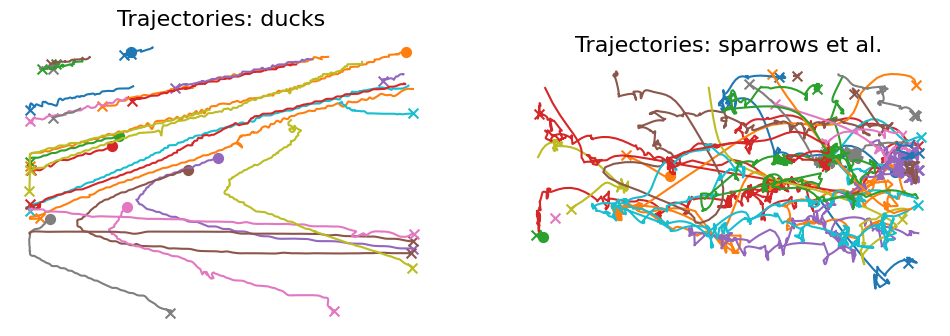

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax1 = ft.plot_trajectories(ducks_raw, "ducks", ax=ax[0], show_legend=False)

ax2 = ft.plot_trajectories(sparrows_raw, "sparrows et al.", ax=ax[1], show_legend=False)

path = os.path.join(root, "docs/figures/fig_bird_trajectories.png")
if not os.path.exists(path):
    plt.savefig(path, dpi=300)

plt.show()

### Analyze mutual distance distribution

The `ft.foragers_to_forager_distances` helper function calculates the distances between foragers at each time frame. It returns a nested list of length `len(obj.foragers)` where sublist `i`  contains `DataFrame`s of distances
between forager `i` and all others, one `DataFrame` per time frame.

This takes a few minutes to run, and results are stored in local .pkl files, which you should delete if you want to re-compute the analysis.

In [4]:
duck_distances_path = os.path.join(
    root, "docs/foraging/central-park-birds/duck_distances.pkl"
)
sps_distances_path = os.path.join(
    root, "docs/foraging/central-park-birds/sps_distances.pkl"
)

if not os.path.exists(duck_distances_path) or not os.path.exists(sps_distances_path):
    duck_distances = ft.foragers_to_forager_distances(obj=ducks_object)
    sps_distances = ft.foragers_to_forager_distances(obj=sps_object)

    with open(duck_distances_path, "wb") as f:
        dill.dump(duck_distances, f)

    with open(sps_distances_path, "wb") as f:
        dill.dump(sps_distances, f)

else:
    print("Loading precomputed distances.")
    with open(duck_distances_path, "rb") as f:
        duck_distances = dill.load(f)

    with open(sps_distances_path, "rb") as f:
        sps_distances = dill.load(f)

Loading precomputed distances.


Here we are using `plot_distances` to conveniently plot the distance histogram over the entire simulation. See Fig. 4(E,F) in [1].

In [5]:
fig = ft.plot_distances(duck_distances, "ducks")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_ducks.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

fig = ft.plot_distances(sps_distances, "sparrows et al.")
fig.show()
path = os.path.join(root, "docs/figures/fig_distance_distribution_sps.png")
if not os.path.exists(path):
    fig.write_image(path, scale=2)

## Inference with a specific quantitative hypothesis

The foraging toolkit can be used to formulate certain parametrized hypotheses regarding certain behaviors, fit different models to the data and compare the strength of the fitted coefficients. Assuming reasonable normalization, stronger coefficients correspond to hypotheses that are more consistent with the data. An example of such analysis is given in [1], Fig. 4(G,H), where the `interaction_length` parameter in `proximity` predictor was varied.

Here we provide an example for computing a single fit (similar to the other demo notebooks), with a hand-selected preferred proximity ($7$) which is expected to be a better fit for ducks than for sparrows. 

In the future, in a separate notebook, we will illustrate a systematic approach to hypothesis choice.

### Predictors derivation

Compute the relevant derived predictors (proximity and access), which will be used later for inference. 

In [6]:
def derive_cp_predictors(data_object, rep, opt):
    window_size = 30
    sampling_fraction = 0.2

    score_kwargs = {
        "nextStep_sublinear_25": {
            "nonlinearity_exponent": 2.5
        },  # chosen to decrease nonlinearity in I/O relationship
    }

    predictor_kwargs = {
        "access": {
            "decay_factor": 0.9,
        },
        "proximity": {
            "interaction_length": 90,
            "optimal_distance": opt,
            "repulsion_radius": rep,
            "proximity_decay": 0.2,
        },
    }

    local_windows_kwargs = {
        "window_size": window_size,
        "sampling_fraction": sampling_fraction,
        "skip_incomplete_frames": False,
    }

    object_derived_DF = ft.derive_predictors_and_scores(
        data_object,
        local_windows_kwargs,
        predictor_kwargs=predictor_kwargs,
        score_kwargs=score_kwargs,
        dropna=True,
        add_scaled_values=True,
    )

    return object_derived_DF


# we will use the same parameters for both species
ducks_derivedDF = derive_cp_predictors(ducks_object, rep=2, opt=7)
sps_derivedDF = derive_cp_predictors(sps_object, rep=2, opt=7)

2024-10-28 16:49:11,062 - access completed in 1.27 seconds.
2024-10-28 16:49:21,107 - proximity completed in 10.04 seconds.
2024-10-28 16:49:22,060 - nextStep_sublinear_25 completed in 0.95 seconds.
/Users/emily/code/collaborative-intelligence/collab/foraging/toolkit/derive.py:56: UserWarning:


                      Dropped 19072/1705366 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      

2024-10-28 16:49:25,006 - access completed in 0.88 seconds.
2024-10-28 16:49:26,372 - proximity completed in 1.37 seconds.
2024-10-28 16:49:26,687 - nextStep_sublinear_25 completed in 0.31 seconds.
/Users/emily/code/collaborative-intelligence/collab/foraging/toolkit/derive.py:56: UserWarning:


                      Droppe

### Predictors visualization
Plot the proximity score for a particular forager (`forager_predictor_indices=[2]`) at different timesteps.

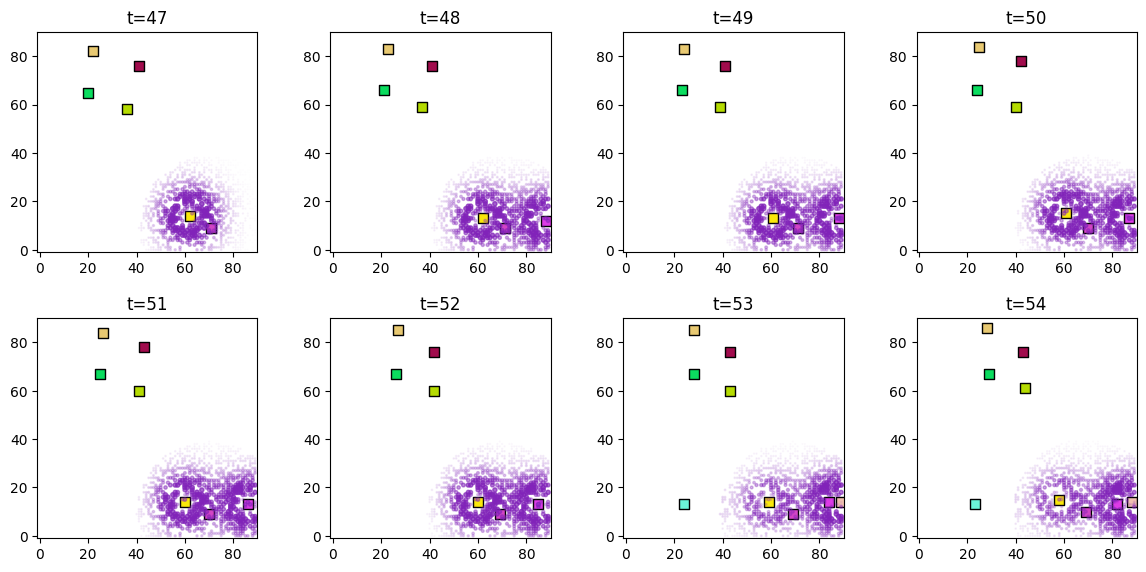

In [7]:
predictor_name = "proximity"
plot_predictor(
    ducks_object.foragers,
    ducks_object.derived_quantities[predictor_name],
    predictor_name=predictor_name,
    time=range(47, 55),
    grid_size=90,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(29)),
    forager_predictor_indices=[2],
)

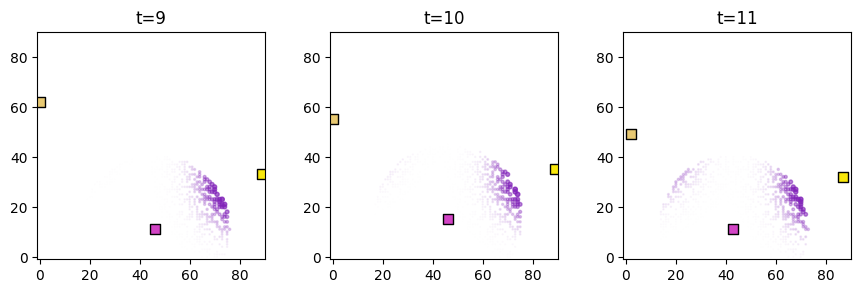

In [8]:
predictor_name = "proximity"
plot_predictor(
    sps_object.foragers,
    sps_object.derived_quantities[predictor_name],
    predictor_name=predictor_name,
    time=range(9, 12),
    grid_size=90,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=list(range(28)),
    forager_predictor_indices=[2],
)

### Model fit
Estimate model coefficients using SVI. 

In [9]:
predictors = ["access", "proximity"]
outcome_vars = ["nextStep_sublinear_25"]

ducks_predictor_dict, ducks_outcome_dict = ft.prep_DF_data_for_inference(
    ducks_derivedDF,
    predictors,
    outcome_vars,
    subsample_rate=0.1,
)

ducks_model = ft.HeteroskedasticLinear(ducks_predictor_dict, ducks_outcome_dict)

ducks_outcome = ft.get_samples(
    model=ducks_model,
    predictors=ducks_predictor_dict,
    outcome=ducks_outcome_dict,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
    plot=False,
    verbose=False,
)

sps_predictor_dict, sps_outcome_dict = ft.prep_DF_data_for_inference(
    sps_derivedDF,
    predictors,
    outcome_vars,
    subsample_rate=0.1,
)

sps_model = ft.HeteroskedasticLinear(sps_predictor_dict, sps_outcome_dict)

sps_outcome = ft.get_samples(
    model=sps_model,
    predictors=sps_predictor_dict,
    outcome=sps_outcome_dict,
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
    plot=False,
    verbose=False,
)

2024-10-28 16:49:28,088 - Sample size: 168629
2024-10-28 16:49:28,089 - Starting SVI inference with 1000 iterations.


[iteration 0200] loss: 340825.9375
[iteration 0400] loss: 340222.9688
[iteration 0600] loss: 340346.9375
[iteration 0800] loss: 340113.4688


2024-10-28 16:49:38,251 - SVI inference completed in 10.16 seconds.


[iteration 1000] loss: 340413.5625


2024-10-28 16:49:39,011 - Sample size: 59925
2024-10-28 16:49:39,012 - Starting SVI inference with 1000 iterations.


[iteration 0200] loss: 116830.9219
[iteration 0400] loss: 116779.1016
[iteration 0600] loss: 116588.3906
[iteration 0800] loss: 116632.0000


2024-10-28 16:49:45,801 - SVI inference completed in 6.79 seconds.


[iteration 1000] loss: 116547.4297


## Results

Finally, we can compare the fit quality. This can be done utilizing `evaluate_performance` method in the foraging toolkit.

### Ducks

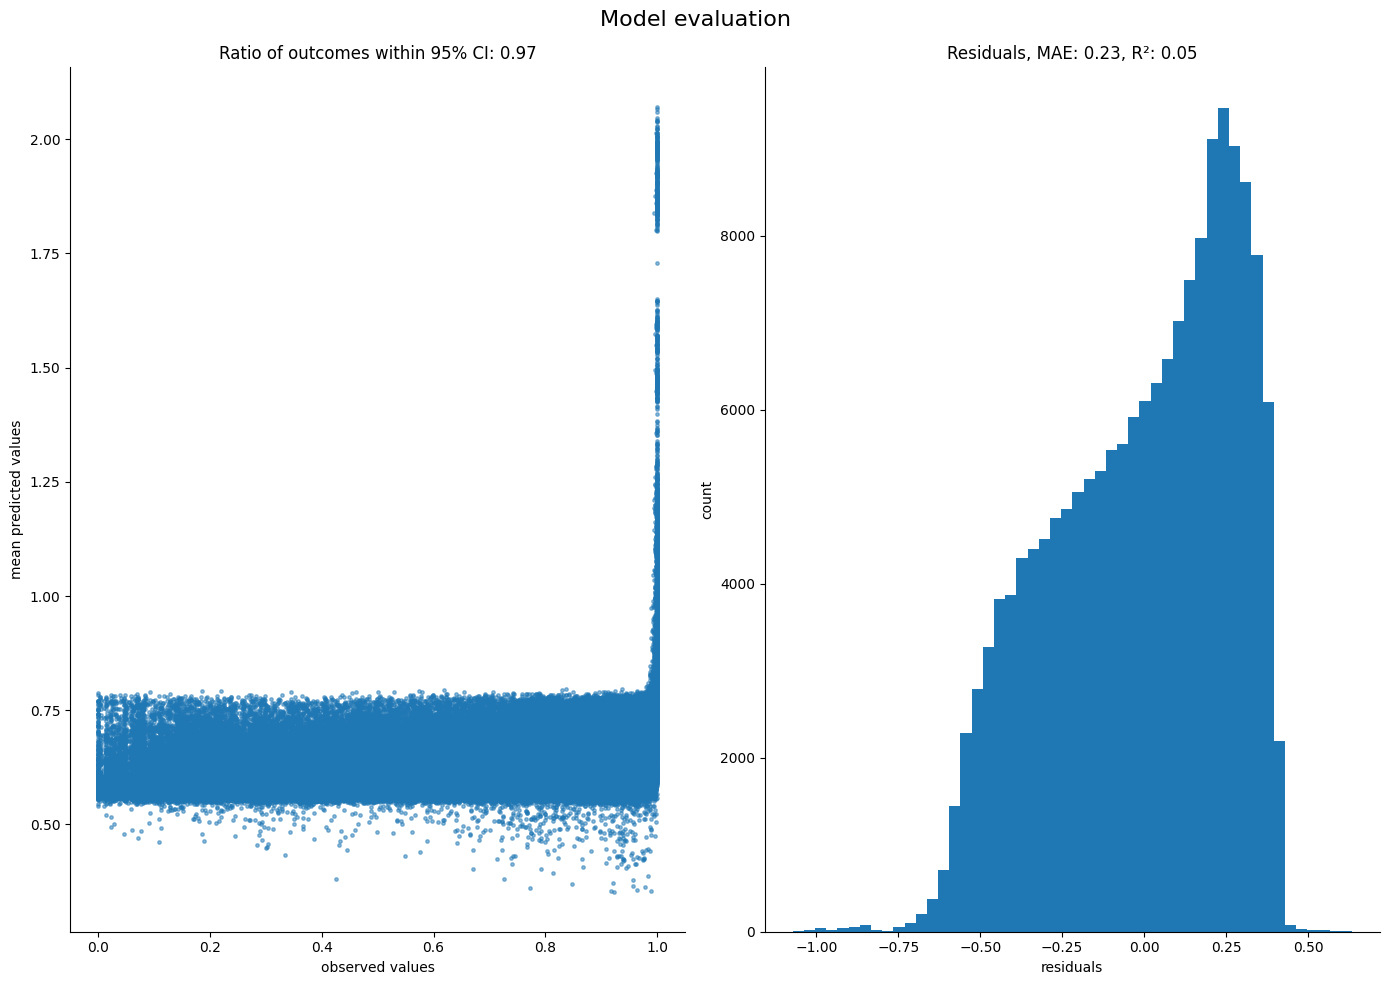

In [10]:
ft.evaluate_performance(
    model=ducks_model,
    guide=ducks_outcome["guide"],
    predictors=ducks_predictor_dict,
    outcome=ducks_outcome_dict,
    num_samples=1000,
)

Poor $R^2$ fit suggests that while the model explains some variance,  clearly there  are many other things that guide the birds that this model does not capture.

An interesting direction will be to tweak the score functional form.

### Sparrows

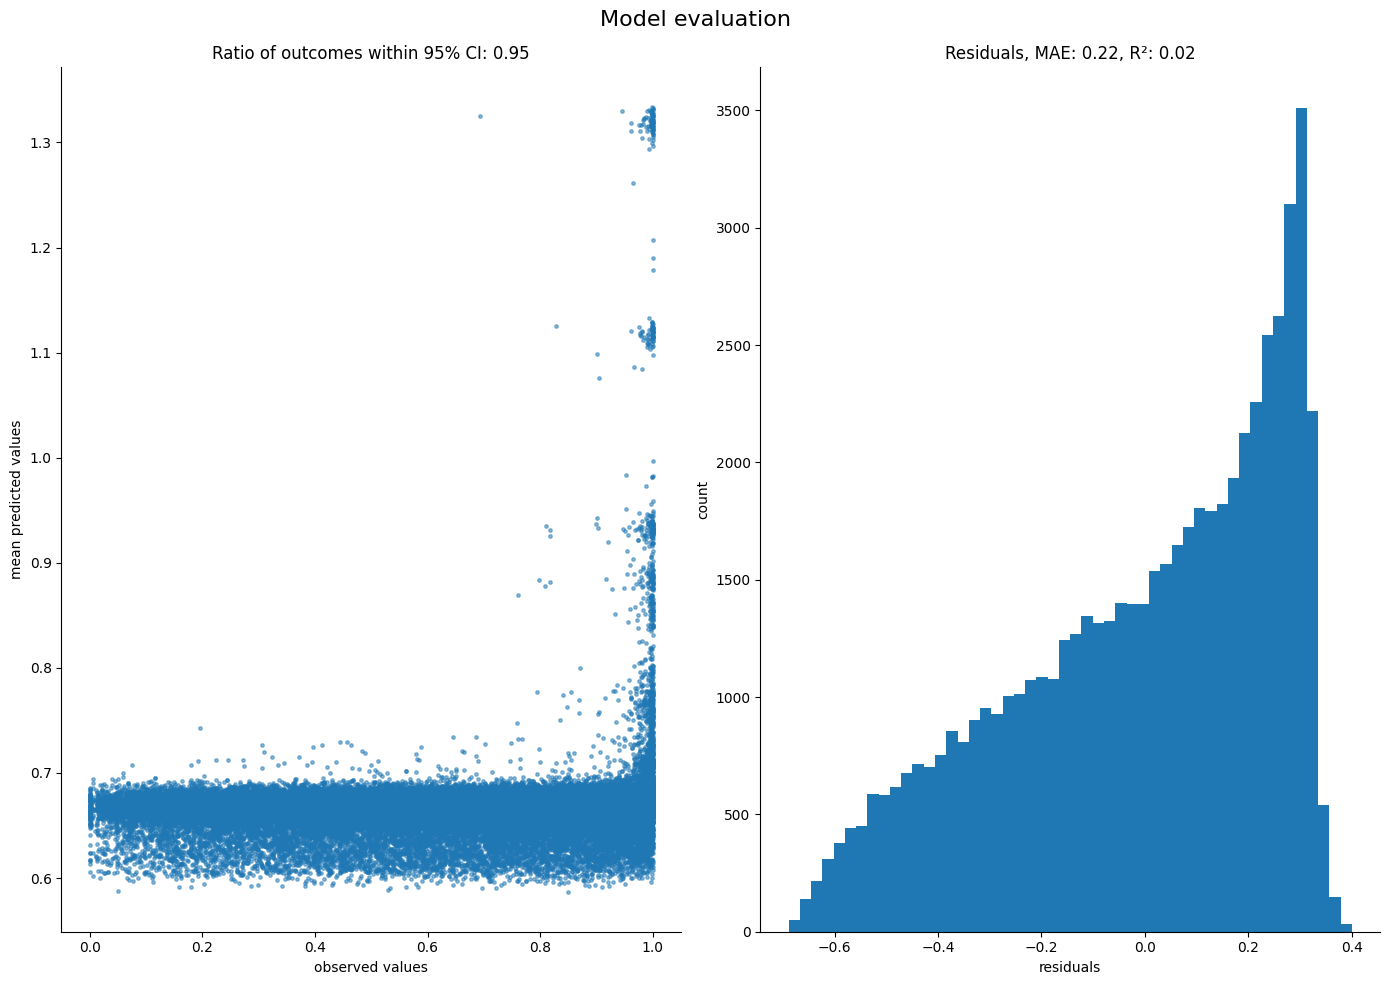

In [11]:
ft.evaluate_performance(
    model=sps_model,
    guide=sps_outcome["guide"],
    predictors=sps_predictor_dict,
    outcome=sps_outcome_dict,
    num_samples=1000,
)

The model provides an even poorer fit to the data.

### Comparison

Now let us compare the fit coefficients for the proximity predictor.

In [12]:
new_key = f"weight_continuous_proximity_{outcome_vars[0]}"
sites = {
    "ducks": ducks_outcome["samples"][new_key],
    "sparrows et al.": sps_outcome["samples"][new_key],
}

ft.plot_coefs(
    sites,
    "Posterior marginal for the proximity coefficients<br>(both models)",
    nbins=120,
    ann_start_y=160,
    ann_break_y=50,
)

Interestingly, negative coefficients suggest that actually the sparrows prefer to avoid large separations.